
# Real-world data coding for neuroscientists (ReCoN)

### MSc in Translational Neuroscience,

### Department of Brain Sciences, Faculty of Medicine,

### Imperial College London

### Contributors: Anastasia Ilina, Cecilia Rodriguez, Marirena Bafaloukou, Katarzyna Marta Zoltowska, Rishideep Chatterjee, Sahar Rahbar, Cynthia Sandor

### Autumn 2025


# 🧠 Computing with Real‑World Medical Data in Python (MSc Translational Neuroscience)
## Tutorial 3 – Tabular data with pandas on Electronic Healthcare Records (EHR)

**Part 2: Data visualisation. Data cleaning and preprocessing with pandas.**






## Learning outcomes

**Overall aim**: develop skills for statistical analysis of longitudinal medical data.

**You will learn to:**
- Effectively visualise distributions, trends and relationships in the data.
- Identify outliers and duplicates in tabular data.
- Handle missing data.


## 📚 Supporting matetial - pandas cheat sheets & tutorials

> A lot of useful information (tutorials & examples) can be found in the official documentation of the libraries we use:
> - [🐼 Pandas documentation](https://pandas.pydata.org/docs/user_guide/index.html)
> - [📊 Matplotlib documentation](https://matplotlib.org/stable/contents.html)
> - [📉 Seaborn documentation](https://seaborn.pydata.org/index.html)

> There are also some cheat sheets that are a great reference for pandas & matplotlib methods:
> - [🐼 Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
> - [📊 Matplotlib Cheat Sheet](https://matplotlib.org/cheatsheets/cheatsheets.pdf)

> There are also useful Matplotlib guides for all levels:
> - [📊 Matplotlib Beginner Handout](https://matplotlib.org/cheatsheets/handout-beginner.pdf)
> - [📊 Matplotlib Intermediate Handout](https://matplotlib.org/cheatsheets/handout-intermediate.pdf)
> - [📊 Matplotlib Tips & Tricks](https://matplotlib.org/cheatsheets/handout-tips.pdf)




#### **Use the code below to create a synthetic dataset for plotting**

In [1]:
# === RUN THIS CELL TO (RE)CREATE THE SYNTHETIC DATASET ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix




# Fixed: 'ethinicity' -> 'ethnicity'
expected_cols = {"LEDD","sex","years_since_dx","age","updrs_iii","patient_id","ethnicity","BMI"}

# Only (re)create if df isn't already present with expected columns
if not (isinstance(globals().get("df"), pd.DataFrame) and expected_cols.issubset(df.columns)):
    rng = np.random.default_rng(0)
    n = 5000

    # ---- Core table ----
    df = pd.DataFrame({
        "patient_id": [f"P{i:04d}" for i in range(n)],
        "sex": rng.choice(["Male","Female"], size=n, p=[0.55, 0.45]),
        "years_since_dx": rng.uniform(0, 12, size=n).round(2),
        "age": rng.normal(62, 8, size=n).round(1),
        "ethnicity": rng.choice(["White", "Black", "Asian", "Other", ""],
                                size=n, p=[0.70, 0.10, 0.10, 0.05, 0.05]),
        "BMI": rng.normal(27, 4, size=n).round(1),
    })

    # ---- LEDD: base + exponential noise (skewed) ----
    df["LEDD"] = (250 + 50*df["years_since_dx"] + rng.exponential(500, size=n)).clip(0).round(1)

    # ---- UPDRS III: realistic 0–132 with progression + heterogeneity ----
    # Patient-level random intercepts (baseline severity) and slopes (annual change)
    unique_ids = df["patient_id"].unique()
    intercepts = pd.Series(np.clip(rng.normal(20, 6, size=len(unique_ids)), 0, 60), index=unique_ids)
    slopes     = pd.Series(np.clip(rng.normal(2.2, 0.9, size=len(unique_ids)), 0, 5), index=unique_ids)

    alpha = df["patient_id"].map(intercepts).to_numpy()
    beta  = df["patient_id"].map(slopes).to_numpy()
    years = df["years_since_dx"].astype(float).to_numpy()
    eps   = rng.normal(0, 5, size=len(df))  # visit-level noise

    updrs = np.clip(alpha + beta*years + eps, 0, 132)
    df["updrs_iii"] = np.round(updrs, 1)

    # Inject a few impossible outliers (>132) for teaching Winsorisation/capping
    n_out = max(20, int(0.004 * len(df)))  # ~0.4% or at least 20 rows
    idx_out = rng.choice(df.index, size=n_out, replace=False)
    df.loc[idx_out, "updrs_iii"] = np.round(rng.uniform(140, 220, size=n_out), 1)

    # ---- Intentional data-entry errors (for cleaning exercises) ----
    # BMI: ×10 typos and negatives
    df.loc[rng.choice(df.index, size=5, replace=False), "BMI"] *= 10
    df.loc[rng.choice(df.index, size=5, replace=False), "BMI"] *= -1
    # Age: negatives and unrealistic high values
    df.loc[rng.choice(df.index, size=5, replace=False), "age"] *= -1
    df.loc[rng.choice(df.index, size=5, replace=False), "age"] += 108

    # ---- Duplicate visits for some patients (longitudinal flavor) ----
    ###reps = df.sample(200, replace=True, random_state=0).copy()
    ##reps["patient_id"] = reps["patient_id"].sample(frac=1.0, random_state=1).values
    #df = pd.concat([df, reps], ignore_index=True)

    # make LEDD and UPDRS higher on average for men 
    df.loc[df["sex"]=="Male", "LEDD"] *= rng.uniform(1.05, 1.15, size=(df["sex"]=="Male").sum())
    df.loc[df["sex"]=="Male", "updrs_iii"] *= rng.uniform(1.05, 1.15, size=(df["sex"]=="Male").sum())

    # ---- MCAR missingness on selected columns ----
    for col, p in [("LEDD", 0.05), ("updrs_iii", 0.10), ("sex", 0.01), ("age", 0.02), ("ethnicity", 0.05)]:
        df.loc[rng.choice(df.index, size=int(p*len(df)), replace=False), col] = np.nan

    # ---- MNAR: LEDD more likely missing when UPDRS is high ----
    high_updrs = df["updrs_iii"] > 45
    # Safeguard: drop NaNs before sampling indices
    high_idx = df.index[high_updrs.fillna(False)]
    if len(high_idx) > 0:
        df.loc[rng.choice(high_idx, size=int(0.3*len(high_idx)), replace=False), "LEDD"] = np.nan

    df.reset_index(drop=True, inplace=True)

    # ---- Summary printout ----
    print(f"Created synthetic dataset with {len(df)} rows")
    print(f"Injected UPDRS>132 outliers: {(df['updrs_iii'] > 132).sum()}")
    print("Missingness (%):")
    print((df[["LEDD","updrs_iii","sex","age","ethnicity","BMI"]].isna().mean()*100).round(1))


Created synthetic dataset with 5000 rows
Injected UPDRS>132 outliers: 17
Missingness (%):
LEDD         10.6
updrs_iii    10.0
sex           1.0
age           2.0
ethnicity     5.0
BMI           0.0
dtype: float64


In [2]:
# ===== Inject duplicates in three buckets =====
# Counts: adjust as you like
n_exact = 40          # exact row duplicates
n_key   = 160         # same patient_id & years_since_dx (not exact)
n_repeat= 300         # legit repeated visits (different years_since_dx)

df_list = [df]

# --- 1) Exact row duplicates: true copy-paste of entire rows ---
idx_exact = rng.choice(df.index, size=n_exact, replace=False)
exact_dups = df.loc[idx_exact].copy()
df_list.append(exact_dups)

# --- 2) Key duplicates: same patient_id & same years_since_dx but slight entry drift ---
# pick base rows
idx_key = rng.choice(df.index.difference(idx_exact), size=n_key, replace=False)
key_dups = df.loc[idx_key].copy()

# Introduce small, realistic data-entry drift to numeric fields (but keep ID + time the same)
def small_perturb(x, scale):
    return np.round(x + rng.normal(0, scale, size=len(x)), 1)

if "LEDD" in key_dups:
    key_dups["LEDD"] = small_perturb(key_dups["LEDD"], scale=15)     # ±15 mg
if "updrs_iii" in key_dups:
    key_dups["updrs_iii"] = np.clip(small_perturb(key_dups["updrs_iii"], scale=1.5), 0, 220)
if "BMI" in key_dups:
    key_dups["BMI"] = np.round(key_dups["BMI"] + rng.normal(0, 0.3, size=len(key_dups)), 1)

# keep patient_id and years_since_dx unchanged (this makes them key duplicates)
df_list.append(key_dups)

# --- 3) Legit repeats: same patient, NEW years_since_dx (and recomputed fields) ---
# choose patients to get an extra visit
rep_patients = rng.choice(df["patient_id"].unique(), size=n_repeat, replace=False)

# For each chosen patient, create a new visit at a later (or earlier) year_since_dx
reps = df[df["patient_id"].isin(rep_patients)].copy()

# Propose a new time that differs from the current one by ~0.5–2.0 years
delta = rng.uniform(0.5, 2.0, size=len(reps))
sign  = rng.choice([1, -1], size=len(reps), p=[0.8, 0.2])  # mostly later visits
new_years = np.clip(reps["years_since_dx"].astype(float).to_numpy() + sign*delta, 0, 12)
reps["years_since_dx"] = np.round(new_years, 2)

# Age moves with time (if you want): comment out if not desired
if "age" in reps:
    reps["age"] = np.round(reps["age"].astype(float) + sign*delta, 1)

# Recompute LEDD and UPDRS for the *new* visit using the same subject-specific intercept/slope
pid = reps["patient_id"]
alpha_rep = pid.map(intercepts).to_numpy()
beta_rep  = pid.map(slopes).to_numpy()
years_rep = reps["years_since_dx"].astype(float).to_numpy()

# fresh noise terms
eps_rep = rng.normal(0, 5, size=len(reps))
updrs_rep = np.clip(alpha_rep + beta_rep*years_rep + eps_rep, 0, 132)
reps["updrs_iii"] = np.round(updrs_rep, 1)

# recompute LEDD with new years_since_dx
led_noise = rng.exponential(500, size=len(reps))
reps["LEDD"] = (250 + 50*reps["years_since_dx"].astype(float) + led_noise).clip(0).round(1)

# Append legit repeats
df = pd.concat(df_list + [reps], ignore_index=True)

# ---- Quick bookkeeping prints ----
print("\nInjected duplicates summary:")
print(f"  Exact duplicates added:         {len(exact_dups)}")
print(f"  Key-duplicates added:           {len(key_dups)}")
print(f"  Legit repeat visits added:      {len(reps)}")

# (OPTIONAL) Sanity counts right now (pre-missingness/multipliers)
exact_count = df.duplicated(keep=False).sum()
key_count   = df.duplicated(subset=['patient_id','years_since_dx'], keep=False).sum()
print(f"  Current exact-dup rows (counted individually): {exact_count}")
print(f"  Current key-dup rows (same patient+time):      {key_count}")



Injected duplicates summary:
  Exact duplicates added:         40
  Key-duplicates added:           160
  Legit repeat visits added:      300
  Current exact-dup rows (counted individually): 80
  Current key-dup rows (same patient+time):      400


In [3]:
# delete the df if needed to recreate a fresh version (uncomment and run if needed)
#del df


> In this dataset, each row represents a **visit of a patient with Parkinson’s disease (PD)**.

> The variable `years_since_dx` shows how long it’s been since diagnosis.

> Because LEDD increases with years since diagnosis, you can think of the LEDD values and UPDRS III values as *cross-sectional* medication doses and clinical test results measured at *varying stages* of PD.

### Let's examine the datasets that we have been provided with. 

We can use pandas .display() and .describe() functions to get a quick overview of the data.


In [4]:
# Show the data
display(df)

,patient_id,sex,years_since_dx,age,ethnicity,BMI,LEDD,updrs_iii
0,P0000,Female,10.62,66.6,White,30.1,818.300000,44.900000
1,P0001,NaN,8.29,52.5,White,27.6,911.936129,31.957703
2,P0002,Male,5.78,63.4,White,19.3,1242.933872,27.852806
3,P0003,Male,8.15,70.2,Black,22.9,1683.987581,34.412344
4,P0004,Female,10.03,53.4,White,20.6,788.200000,35.400000
...,...,...,...,...,...,...,...,...
5495,P4932,Male,4.84,64.3,Black,24.7,1245.600000,39.300000
5496,P4942,Female,4.14,57.1,White,27.7,1501.400000,38.500000
5497,P4945,Male,5.78,51.6,White,27.6,1314.600000,41.400000
5498,P4968,Male,2.92,79.4,White,28.1,631.800000,24.200000


In [5]:
# Number of participants
df["patient_id"].nunique()

5000

> As you can see, some of the patients have multiple visits 

In [6]:
# describe the data
df.describe()

,years_since_dx,age,BMI,LEDD,updrs_iii
count,5500.000000,5391.000000,5500.000000,4950.000000,4981.000000
mean,6.021167,62.133927,27.141745,1099.492073,35.269241
std,3.459429,9.468886,9.206402,571.483863,16.248238
min,0.000000,-73.600000,-30.900000,238.600000,0.000000
25%,3.027500,56.800000,24.300000,715.152853,25.387597
50%,6.045000,62.100000,27.000000,959.100000,33.900000
75%,9.000000,67.700000,29.600000,1347.033845,43.350714
max,12.000000,181.900000,355.000000,6265.363225,237.617425


## ✏️ Now let's do some visualisations! 
### 📊 Histogram — distribution of a single variable
**When to use**: Explore the distribution of a numeric feature (e.g., age, LEDD)

**Tips**: Choose sensible bin counts; consider a log-scale if the tail is heavy


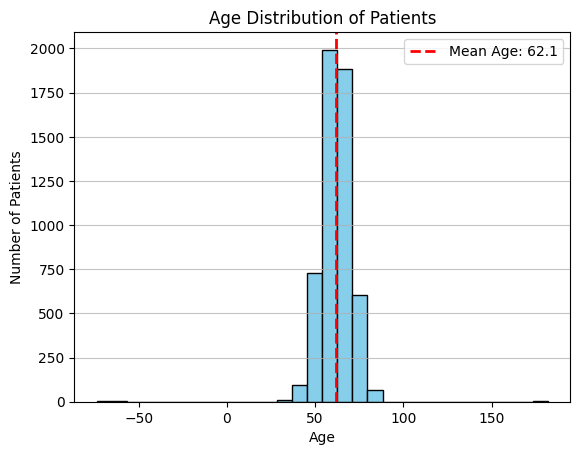

In [7]:
import matplotlib.pyplot as plt
# plot the histogram of age
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
# Add a vertical line for the mean age
plt.axvline(df['age'].mean(), color='red', linestyle='dashed', linewidth=2)
# add a legend for the mean line with its value
plt.legend([f'Mean Age: {df["age"].mean():.1f}'])
plt.grid(axis='y', alpha=0.75)
plt.show()

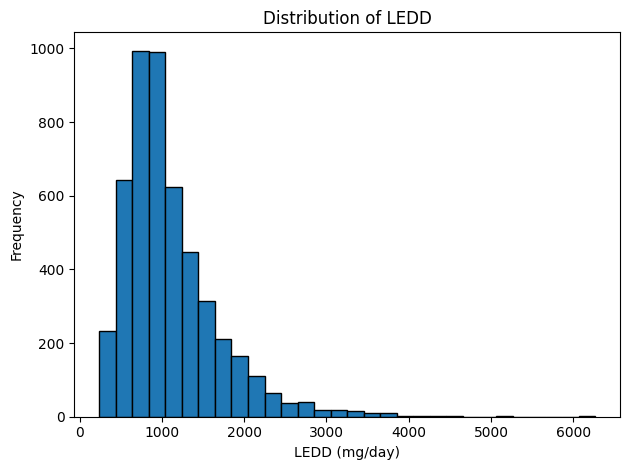

In [8]:
## Now let's plot the LEDD distribution

plt.figure()
plt.hist(df["LEDD"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of LEDD")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


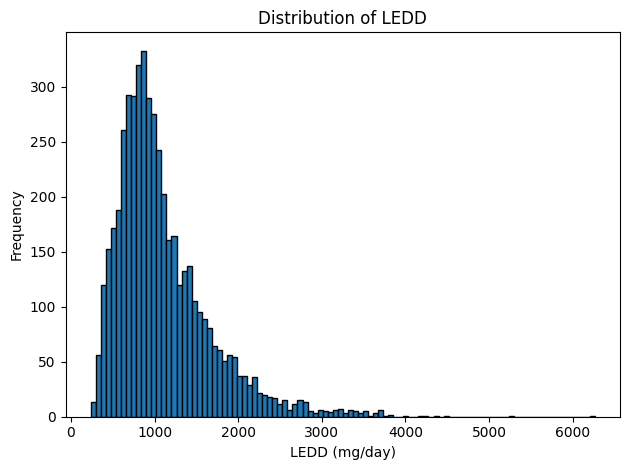

In [9]:
# Let's see what happens when we adjust the number of bins!
plt.figure()
plt.hist(df["LEDD"].dropna(), bins=100, edgecolor="black")
plt.title("Distribution of LEDD")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


You can also save the figures you create using plt.savefig() and specify the file format you want to save it in (e.g., .png, .jpg, .pdf) and the resolution (dpi).


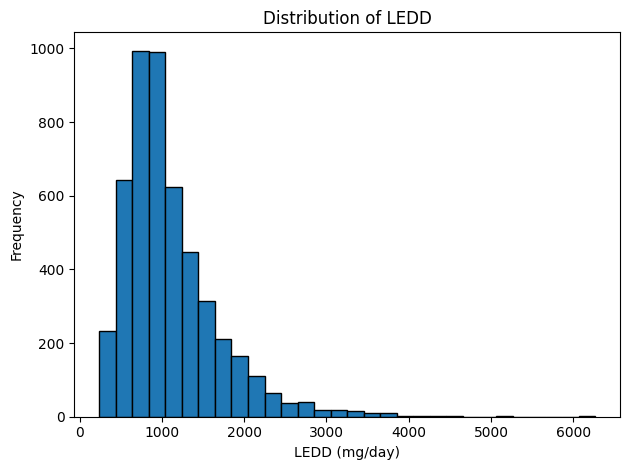

In [10]:
# Let's save a hisotgram of LEDD distribution in PNG format at 300 dpi
plt.figure()
plt.hist(df["LEDD"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of LEDD")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("ledd_distribution.png", dpi=300)
plt.show()




In our histogram, notice that **LEDD** has a **long right tail** — a few patients take **very high doses** of medication compared to the rest.
This kind of pattern is a good illustration of a **right-skewed** or **heavy-tailed** distribution that we talked about earlier. It is pretty common in medical data.

### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

* What would be **the ordering** of the measures of central tendency (mean, median, mode) for this distribution if we plotted them? 

* **Plot** the **mean, median**, and **mode** on the histogram above using vertical lines to check your answer! Add the values to the legend for the bonus points!
* Try different numbers of bins (e.g., 5, 10,  20, 50, 100) and see how it affects the histogram shape.




In [11]:
# Write your code here

### <span style="color:red">If you've done things correcty, you should observe something like this: </span>

![](images/IMG_2882.jpg)


### <span style="color:red">Also, the value of the mode might be a bit surprising. Why is that? </span>

### 📈 Using Logarithmic Scales


![](images/IMG_2871.WEBP)

So, how can we better visualise such skewed data?
A **log transform** helps us *see* and *analyze* such data more clearly:

* It **compresses large values**, so the tall bars on the right no longer dominate the plot.
* It **stretches smaller values**, revealing detail in the lower range.
* As a result, the distribution often looks **more balanced and symmetric**, which can make statistical comparisons easier.


We can do this in two ways:

1. **Log-scale the y-axis** → keeps the data as-is but rescales the frequency axis.
2. **Plot the log of the variable** → transforms the data itself before plotting.

Here’s an example using a **log-scaled y-axis**:

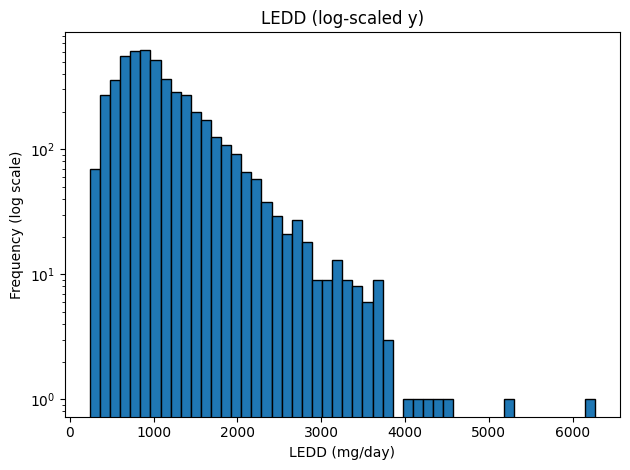

In [12]:

plt.figure()
plt.hist(df["LEDD"].dropna(), bins=50, edgecolor="black", log=True)
plt.title("LEDD (log-scaled y)")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Frequency (log scale)")
plt.tight_layout(); plt.show()


And here's an example of plotting the **log of LEDD** directly:

Text(0.5, 0, 'log(LEDD + 1)')

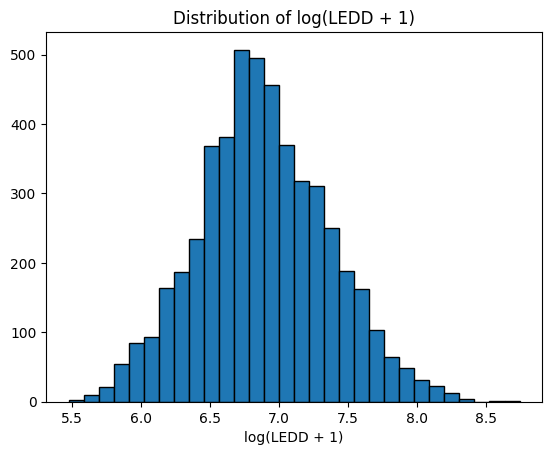

In [13]:
# log-transform the LEDD values
df["log_LEDD"] = np.log1p(df["LEDD"])  # log(LEDD + 1) to handle zero values
# Show the log_LEDD distribution
plt.figure()
plt.hist(df["log_LEDD"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of log(LEDD + 1)")
plt.xlabel("log(LEDD + 1)")         

### 📦 Boxplot — comparing group

**Concept**
Box plots are compact graphical summaries of the distribution of a quantitative variable. They were introduced by **John Tukey (1977)** as part of *Exploratory Data Analysis* to visualise central tendency, spread, and outliers without assuming any particular underlying distribution.

In the context of **Electronic Health Record (EHR)** or **clinical datasets**, variables such as medication dose, biomarker concentration, or symptom score often exhibit **skewed**, **non-normal**, and **heterogeneous** distributions.
Box plots provide an immediate overview of these properties across patient subgroups (for example, *LEDD by sex*, or *UPDRS III by disease stage*).


### 🧠 What a Box Plot Shows

| Component                | Statistical meaning                                                                                                                                 | Interpretation                                            |
| ------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| **Box (IQR)**            | Spans from 25th (Q1) to 75th percentile (Q3). The **height** represents the **interquartile range (IQR)**, containing the central 50 % of the data. | Range of "typical" medication doses or scores.                          |
| **Median line**          | The line inside the box marks the 50th percentile (Q2).                                                                                             | Typical patient’s value (robust to outliers).                           |
| **Whiskers**             | Extend to the most extreme data points within `Q1 − 1.5 × IQR` and `Q3 + 1.5 × IQR` (by default). Points beyond are flagged as *outliers*.          | Captures the expected variability across patients.                      |
| **Outliers**             | Observations outside the whiskers (often shown as dots).                                                                                            | Possible data entry errors, rare clinical cases, or extreme phenotypes. |
| **Notches** *(optional)* | Approximate a 95 % confidence interval around the median. Overlapping notches suggest non-significant differences.                                  | Useful when comparing treatment groups or sexes.                        |



🔎 **IQR rule**

 $ \text{IQR} = Q_3 - Q_1 $   
 $ \text{Outlier thresholds} = ( [Q_1 - 1.5·\text{IQR},, Q_3 + 1.5·\text{IQR}] ) $


#### 🧰 1. Box plots with **pandas**

`DataFrame.boxplot()` provides a quick summary using Matplotlib under the hood.

**Key parameters**

* `showfliers=False` – hide outlier markers (useful for dense data).
* `whis=(5,95)` – whiskers at specific percentiles instead of 1.5 × IQR.
* `notch=True` – display a confidence interval around the median.
* `vert=False` – horizontal orientation (useful for long category names).


<Figure size 640x480 with 0 Axes>

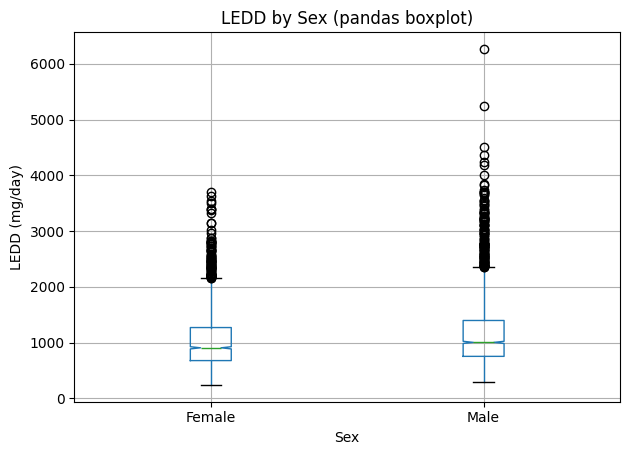

In [14]:
plt.figure()
df.boxplot(column="LEDD", by="sex", showfliers=True, notch=True, whis=1.5)
plt.title("LEDD by Sex (pandas boxplot)")
plt.suptitle("")  # remove auto super-title
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

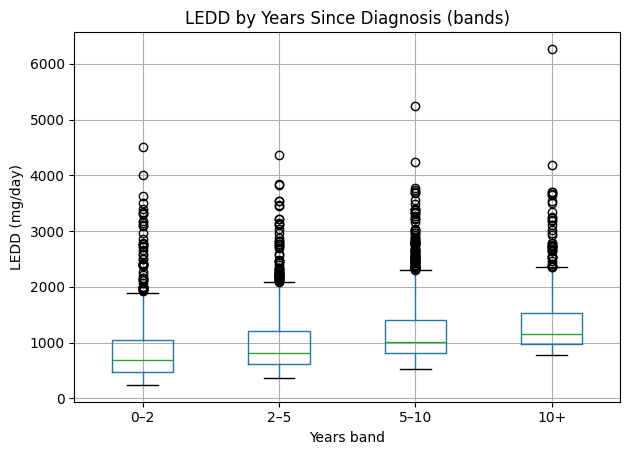

In [15]:
df["years_band"] = pd.cut(df["years_since_dx"], bins=[-0.01,2,5,10,20], labels=["0–2","2–5","5–10","10+"])
plt.figure()
df.boxplot(column="LEDD", by="years_band")
plt.title("LEDD by Years Since Diagnosis (bands)")
plt.suptitle("")
plt.xlabel("Years band")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()



### 🎨 2. Box plots with **matplotlib**

Matplotlib’s `ax.boxplot()` exposes all graphical components for customisation (colour, width, median line style, etc.).

You can:

* add `ax.set_yscale("log")` to visualise heavy-tailed medication data,
* overlay jittered points or mean lines for richer interpretation.







C:\Users\rishi\AppData\Local\Temp\ipykernel_42532\1326043903.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=groups, patch_artist=True, notch=True)


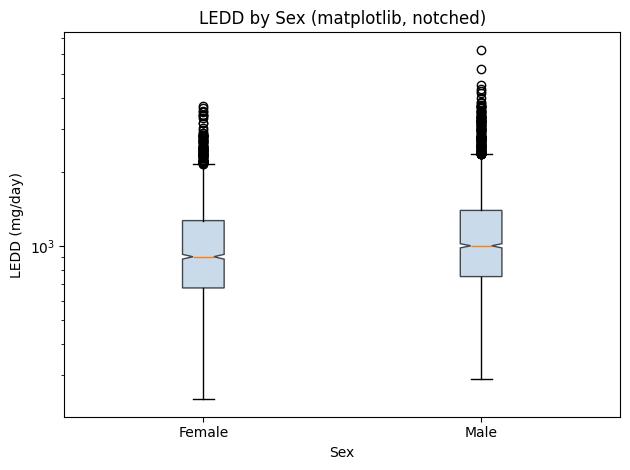

In [16]:
groups = ["Female", "Male"]
data = [df.loc[df["sex"].eq(g), "LEDD"].dropna() for g in groups]

fig, ax = plt.subplots()
bp = ax.boxplot(data, labels=groups, patch_artist=True, notch=True)
for box in bp["boxes"]:
    box.set(facecolor="#b3cde3", alpha=0.7)
ax.set_title("LEDD by Sex (matplotlib, notched)")
ax.set_xlabel("Sex")
ax.set_ylabel("LEDD (mg/day)")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

### 🧩 3. Box and Violin Plots with **seaborn**

Seaborn simplifies comparative distribution plots and handles grouping, colour palettes, and statistical overlays.

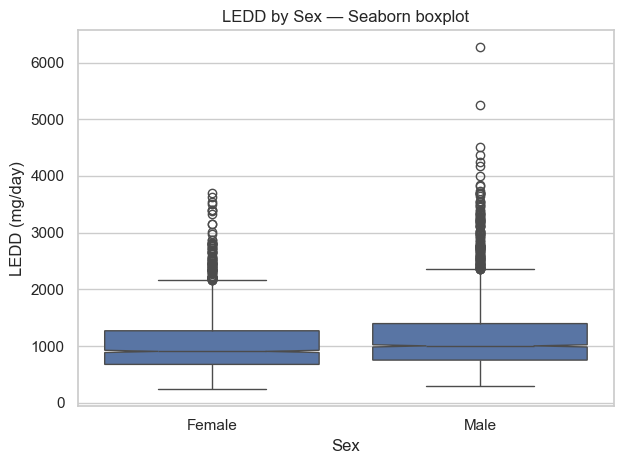

In [17]:


import seaborn as sns
sns.set_theme(style = "whitegrid")

plt.figure()
sns.boxplot(x="sex", y="LEDD", data=df, whis=1.5, showfliers=True, notch=True)
plt.title("LEDD by Sex — Seaborn boxplot")
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()


#### Violin plots — shape of the distribution

Violin plots combine a **kernel density estimate (KDE)** with the summary information of a box plot.
They reveal **asymmetry** and **multi-modality**, which are often hidden in box plots.


C:\Users\rishi\AppData\Local\Temp\ipykernel_42532\4116782057.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="sex", y="LEDD", data=df, inner="quartile", cut=0, scale="width")


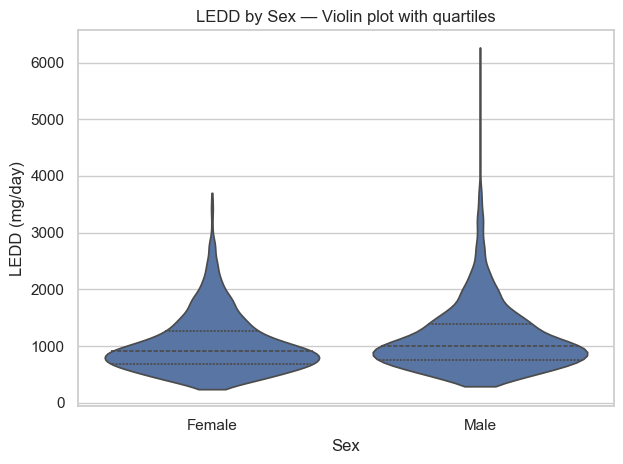

In [18]:


plt.figure()
sns.violinplot(x="sex", y="LEDD", data=df, inner="quartile", cut=0, scale="width")
plt.title("LEDD by Sex — Violin plot with quartiles")
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()



#### Combining multiple factors





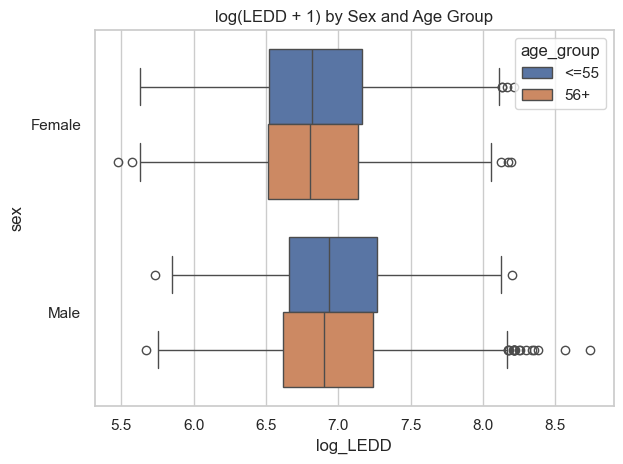

In [19]:
# create before/after 55 age groups (already in your code)
plt.figure()
df["age_group"] = pd.cut(df["age"], bins=[0,55,100], labels=["<=55","56+"])
sns.boxplot(x="log_LEDD", y="sex", hue="age_group", data=df)
plt.title("log(LEDD + 1) by Sex and Age Group")
plt.tight_layout()
plt.show()

#### Boxen plots (Letter-Value plots)

For large (n) (e.g., thousands of EHR records), **boxen plots** visualise many quantiles, providing a more detailed view of the tails.

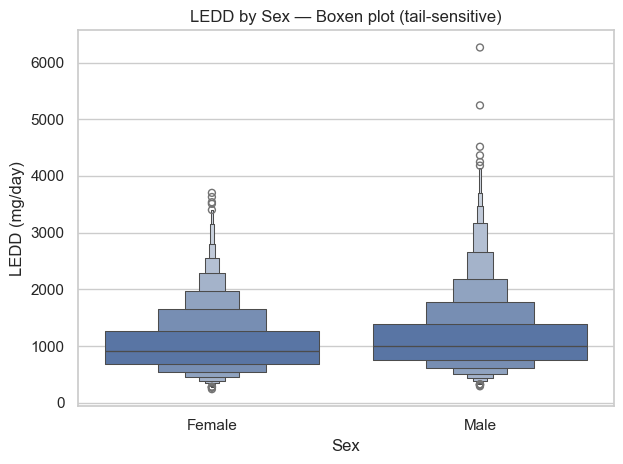

In [20]:
plt.figure()
sns.boxenplot(x="sex", y="LEDD", data=df)
plt.title("LEDD by Sex — Boxen plot (tail-sensitive)")
plt.xlabel("Sex")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout()
plt.show()


### 🎯 Strip and Swarm Plots — Visualising Individual Observations

**Concept**

While box and violin plots summarise distributions, they can **hide the underlying data points** — important in biomedical datasets where:

* The number of observations per group may differ,
* Extreme values (e.g., very high LEDD) might reflect real clinical phenomena, and
* Visualising every data point can reveal *clusters, subgroups,* or *data entry errors*.

**Strip** and **swarm** plots show individual observations along a category axis:

* A **strip plot** adds random *jitter* to avoid overlap — good for small to moderate sample sizes.
* A **swarm plot** uses a smarter algorithm that avoids overlaps while preserving relative density — ideal for teaching and publication figures.

> Both are part of Seaborn’s *categorical plots* API and integrate seamlessly with box and violin plots.


### 🧩 Example 1 — Simple strip plot

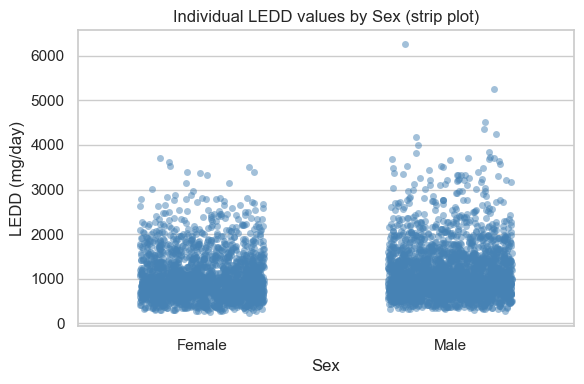

In [21]:
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.stripplot(
    x="sex", y="LEDD", data=df,
    jitter=0.25, alpha=0.5, color="steelblue"
)
plt.title("Individual LEDD values by Sex (strip plot)")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

**Explanation**

* `jitter=0.25` adds small horizontal randomness to avoid overplotting.
* `alpha=0.5` makes overlapping points transparent.
* The overall height of each cloud approximates the data distribution.


### 🧩 Example 2 — Swarm plot (better spacing, density-aware)

c:\Users\rishi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rishi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rishi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rishi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 58.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

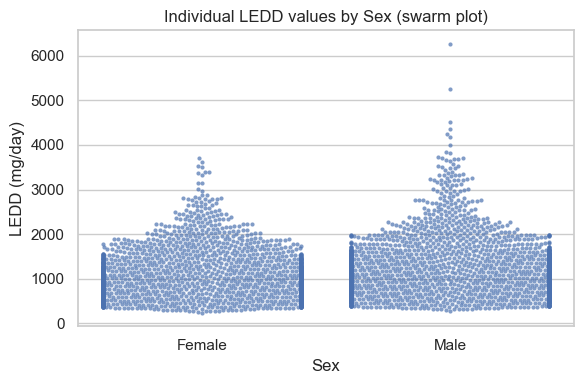

In [22]:
plt.figure(figsize=(6, 4))
sns.swarmplot(
    x="sex", y="LEDD", data=df,
    size=3, color="#4C72B0", alpha=0.7
)
plt.title("Individual LEDD values by Sex (swarm plot)")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

**Explanation**

* Swarm plots arrange points to avoid overlap entirely, revealing *local density* and *outliers*.
* The vertical spread still reflects data values; horizontally, points are offset for visibility only.
* For large (n > 5000), sampling (`df.sample(1000)`) is recommended for performance.


### 🧩 Example 3 — Combining swarm and boxplot (best of both worlds)

This combination is commonly used in academic and clinical data visualisation: the **boxplot summarises** central tendency and IQR, while the **swarm overlay** reveals actual data points.

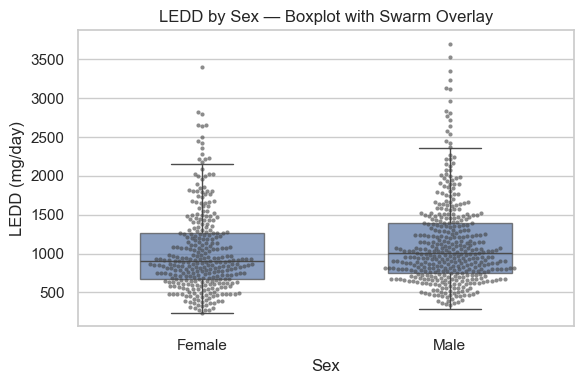

' \nThe random_state parameter here is used in functions that involve randomness (like shuffling or sampling); \nsetting it to a specific integer (e.g., random_state=42) ensures that the random process will produce the exact \nsame result every time you run the code. This is essential for reproducibility.\n'

In [23]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="sex", y="LEDD", data=df,
    whis=1.5, showfliers=False, width=0.5,
    boxprops=dict(alpha=0.7)
)
sns.swarmplot(
    x="sex", y="LEDD", data=df.sample(800, random_state=1),
    size=3, color="0.25", alpha=0.6
)
plt.title("LEDD by Sex — Boxplot with Swarm Overlay")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()


""" 
The random_state parameter here is used in functions that involve randomness (like shuffling or sampling); 
setting it to a specific integer (e.g., random_state=42) ensures that the random process will produce the exact 
same result every time you run the code. This is essential for reproducibility.
"""


**Interpretation in context**

* The box summarises median and IQR (typical dose range).
* The swarm points reveal **within-group variability**, **asymmetry**, and **potential outliers**.
* Particularly in clinical datasets, this helps distinguish **data artefacts** (isolated dots far outside the whiskers) from **genuine but rare cases**.


#### 🧮 Example 4 — Multigroup swarm (LEDD by sex × age group)

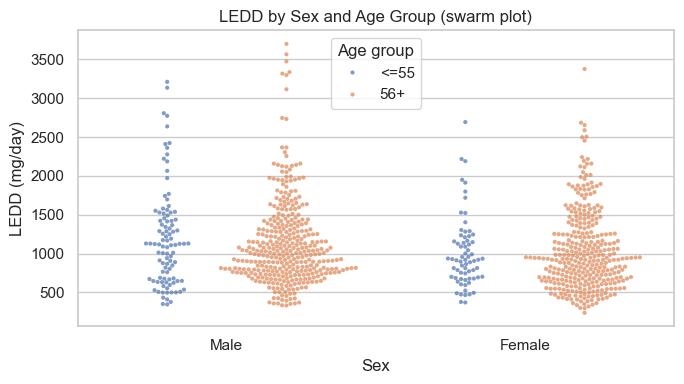

In [24]:
plt.figure(figsize=(7, 4))
sns.swarmplot(
    x="sex", y="LEDD", hue="age_group",
    data=df.sample(1000, random_state=0),
    dodge=True, size=3, alpha=0.7
)
plt.title("LEDD by Sex and Age Group (swarm plot)")
plt.xlabel("Sex"); plt.ylabel("LEDD (mg/day)")
plt.legend(title="Age group")
plt.tight_layout(); plt.show()



### 🧠 Choosing & Interpreting Distribution Plots (clinical/EHR data)

Use the guide below to decide which plot to use for LEDD, UPDRS III, lab values, etc., and how to read them in a biomedical context.

#### Master comparison

| Plot / Scale          | When to use                                                 | Advantages                                         | Limitations / Caveats                                      |
| --------------------- | ----------------------------------------------------------- | -------------------------------------------------- | ---------------------------------------------------------- |
| **Box plot**          | Quick comparison of central tendency & spread across groups | Robust to outliers; compact; widely understood     | Minimal detail on distribution shape                       |
| **Violin plot**       | Assess distribution **shape** / multimodality               | Shows KDE density + quartiles (`inner="quartile"`) | Sensitive to bandwidth; individual points not shown        |
| **Boxen plot**        | Large samples; emphasise **tails** and extreme quantiles    | More quantiles than box; tail-sensitive            | Less familiar to audiences than box/violin                 |
| **Strip plot**        | Small/medium *n*; show raw points quickly                   | Simple; reveals outliers and clustering            | Overplotting at high density; relies on random jitter      |
| **Swarm plot**        | Medium *n*; teaching/publication figures with raw points    | Density-aware, non-overlapping, visually clear     | Slower and may fail to place all points for very large *n* |
| **Box + swarm**       | Balanced **summary + raw** overlay                          | Median/IQR + individual variability in one view    | Visual clutter if *n* very large (sample first)            |
| **Log-scaled y-axis** | Heavy-tailed variables (e.g., LEDD, biomarkers)             | Compresses extremes; reveals lower-range structure | Transforms perception of differences; explain to audience  |

---

### 🧩 Interpretation in a biomedical context

* **Wide IQRs** (box height) → heterogeneity in disease progression or treatment response.
* **Outliers** (beyond 1.5×IQR whiskers) → possible data entry errors, rare phenotypes, or clinically distinct subgroups; verify before removal.
* **Skew/asymmetry** → dosing ceilings/floors, clinician behaviour, or measurement limits; consider log scaling.
* **Group differences** (e.g., higher LEDD in males) → visual patterns should precede formal testing; report effect sizes and clinical relevance, not only *p*-values.


### 📚 References

* Tukey, J.W. (1977). *Exploratory Data Analysis.* Addison-Wesley.
* McGill, R., Tukey, J.W., & Larsen, W.A. (1978). *Variations of Box Plots.* **The American Statistician**.
* **Matplotlib** `pyplot.boxplot`: [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)
* **Seaborn** categorical plots tutorial: [https://seaborn.pydata.org/tutorial/categorical.html](https://seaborn.pydata.org/tutorial/categorical.html)
* **Seaborn** `violinplot`: [https://seaborn.pydata.org/generated/seaborn.violinplot.html](https://seaborn.pydata.org/generated/seaborn.violinplot.html)
* Waskom, M.L. (2021). *Seaborn: statistical data visualization.* **JOSS**, 6(60), 3021.


### 🔴 Scatter plot 
Scatter plots are used to visualise the relationship between two continuous variables. Each point represents an observation in the dataset, with its position determined by the values of the two variables being compared.


**Tips**:
* Use `alpha` (transparency) to reduce overplotting.
* Use `hue` for groups; optionally add `style` or `size`.
* Always drop NaNs for the variables you plot.



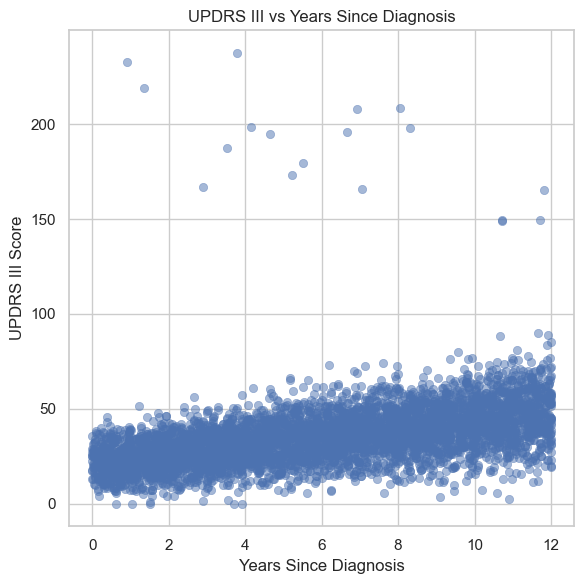

In [25]:
from matplotlib.pyplot import figure

cols = ["years_since_dx", "updrs_iii", 'sex']
df_plot= df.dropna(subset=cols)

figure(figsize=(6, 6))
sns.scatterplot(
    x="years_since_dx", y="updrs_iii",
    data=df_plot,
    alpha=0.5, edgecolor=None
)
plt.title("UPDRS III vs Years Since Diagnosis")
plt.xlabel("Years Since Diagnosis")
plt.ylabel("UPDRS III Score")
plt.tight_layout()
plt.show()




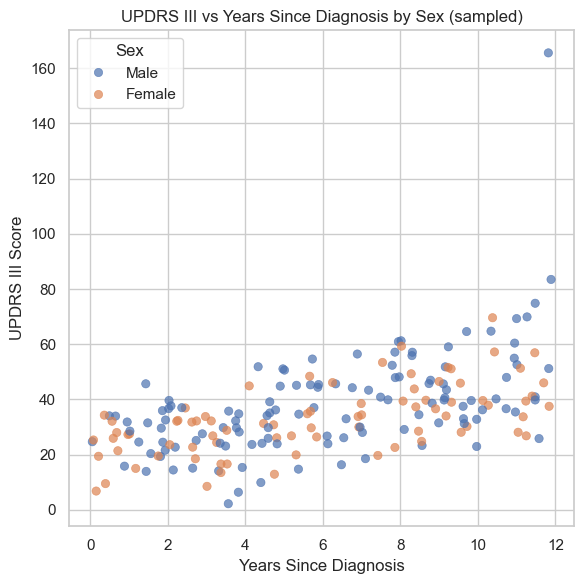

In [26]:

# Now let's look at just 200 random points to reduce overplotting and separate the groups by sex
sampled_df = df_plot.sample(n=200, random_state=42)
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="years_since_dx", y="updrs_iii",
    hue="sex",
    data=sampled_df,
    alpha=0.7, edgecolor=None
)
plt.title("UPDRS III vs Years Since Diagnosis by Sex (sampled)")
plt.xlabel("Years Since Diagnosis")
plt.ylabel("UPDRS III Score")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()  


---
## 🔎 Outliers & Data Entry Errors (theory → practice)

In clinical or EHR data, **outliers** are data points that look very different from the rest. **Outliers** and **data entry errors** are inevitable:

* Negative or implausible values (e.g., negative age, LEDD = 0.001 mg)
* Measurement or unit errors (e.g., mg ↔ g)
* Typing errors (extra zero → 5000 mg instead of 500)
* Genuine extreme patients (important to *keep* if plausible)

Before you impute missing data, always **check for and correct outliers** — otherwise, they can bias averages and distort imputation.

There’s no single “correct” way to detect outliers — instead, we use simple *rules of thumb* to **flag** unusual values for inspection.


### What to look for

* **Domain/range checks**: values outside plausible clinical ranges (e.g., rasagiline > 1 mg/day).
* **Impossible signs**: negative doses.
* **Unit mixups**: mg↔g (10×–1000× too big/small).
* **Distributional outliers**: IQR rule, z-scores.
* **Time-series anomalies**: sudden unrealistic jumps within a patient trajectory.

### What to do

* **Flag** → **Decide** (set to `NaN` & later impute, or clip to plausible range) → **Document**.
* It's considered a good practice to keep **a “raw” copy** and **a “cleaned” copy**. In this way, you can always refer back to the original data if needed, and run **sensitivity analyses** - for example, checking how results change with or without outliers.

###  Theory summary

| Concept           | Definition                                                 | Example / use in EHR                   |
| ----------------- | ---------------------------------------------------------- | -------------------------------------- |
| **Domain checks** | Apply known clinical ranges (e.g., LEDD > 0 mg, Age < 100) | Remove impossible values early         |
| **Z-score**       | Standardised value, flag cases where abs(z) > 3               | Detect statistically rare points       |
| **IQR rule**      | Define fences: Q1 − 1.5 × IQR, Q3 + 1.5 × IQR              | Robust to skewed data                  |
| **Winsorisation** | Cap extremes at chosen quantiles (e.g., 1 % / 99 %)        | Keeps extremes but limits their effect |

---

### Why this step comes **before** imputation

* Outliers can **pull the mean/variance**, biasing simple imputation and even MICE.
* Logging errors (negatives, mg↔g mixups, “0.001 mg”) should become `NaN` (or be clipped) **before** computing imputation statistics.


**Docs:** SciPy [`stats.zscore`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html), [`mstats.winsorize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html)

---
Now let's apply these principles to our Parkinson's dataset!

#### 1️⃣ Quick descriptive overview

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
years_since_dx,5500.0,6.021167,3.459429,0.000000,3.027500,6.045000,9.000000,12.000000
age,5391.0,62.133927,9.468886,-73.600000,56.800000,62.100000,67.700000,181.900000
BMI,5500.0,27.141745,9.206402,-30.900000,24.300000,27.000000,29.600000,355.000000
LEDD,4950.0,1099.492073,571.483863,238.600000,715.152853,959.100000,1347.033845,6265.363225
updrs_iii,4981.0,35.269241,16.248238,0.000000,25.387597,33.900000,43.350714,237.617425
log_LEDD,4950.0,6.888295,0.474591,5.478971,6.573894,6.867037,7.206402,8.742951


This gives you a feel for the **range** of each numeric column and how extreme some values might be.

#### 2️⃣ Visualise BMI distribution and spot potential outliers

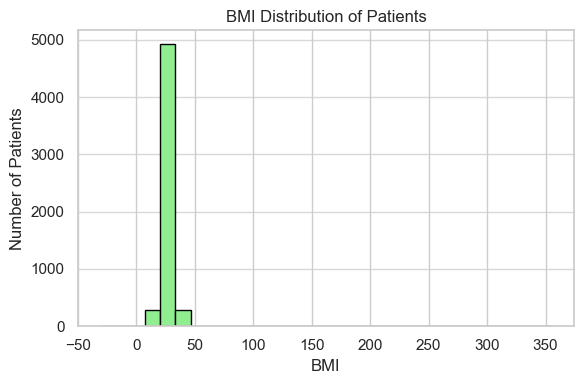

In [28]:
plt.figure(figsize=(6, 4))
plt.hist(df['BMI'].dropna(), bins=30, edgecolor='black', color='lightgreen')
plt.title('BMI Distribution of Patients')
plt.xlabel('BMI')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

> 💡 Normally, you would expect to see a roughly bell-shaped curve between 18–35. However, here, the scale of the graph looks off. Let's plot it with the log-scale to examine what happened.

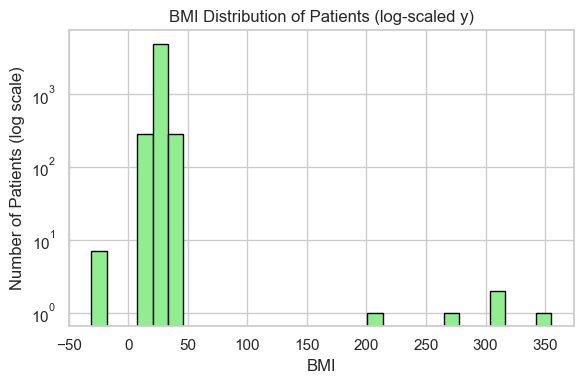

In [29]:
# Plot the histogram with log-scaled y-axis
plt.figure(figsize=(6, 4))
plt.hist(df['BMI'].dropna(), bins=30, edgecolor='black', color='lightgreen', log=True)
plt.title('BMI Distribution of Patients (log-scaled y)')
plt.xlabel('BMI')
plt.ylabel('Number of Patients (log scale)')    
plt.tight_layout(); plt.show()



> As you can see, there are some extreme outliers on the right side of the distribution, which are likely due to data entry errors. This is a common issue in real-world datasets, especially in clinical settings where data entry can be prone to mistakes. Identifying and addressing these outliers is crucial for ensuring the accuracy of subsequent analyses.

You can similarly see the extreme outliers when you're doing the **scatter plot** between BMI and any other variable of interest, for example, LEDD.

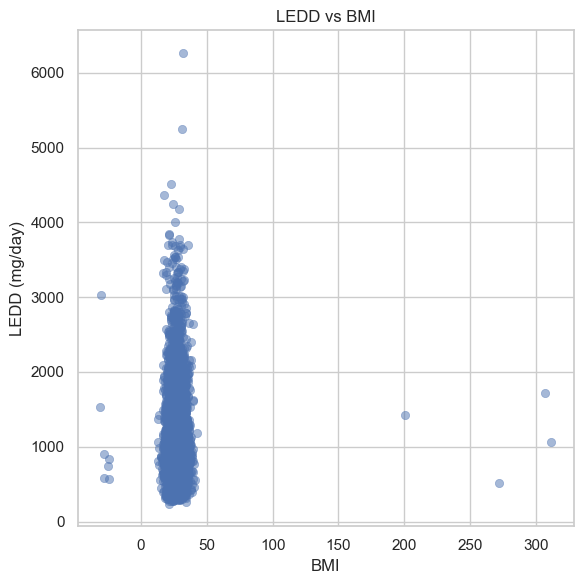

In [30]:
# plote a scatter plot between BMI and LEDD
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x="BMI", y="LEDD",
    data=df,
    alpha=0.5, edgecolor=None
)
plt.title("LEDD vs BMI")
plt.xlabel("BMI")
plt.ylabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

> As you can see, the outliers appear as isolated points far away from the main cluster of data. 

### 3️⃣ Detect BMI outliers statistically
We’ll use both the **IQR rule** (robust to skew) and the **Z-score** method (useful for normally distributed data).


#### 📊 The IQR rule (Interquartile Range)

The **IQR** looks at the “middle 50%” of your data.

Imagine lining up all BMI values from smallest to largest:

* The **median (Q2)** splits the data in half. It is shown in red on the boxplot.
* The **first quartile (Q1)** is the 25th percentile — where 25% of data are smaller. It is shown as boxplot borders on the boxplot.
* The **third quartile (Q3)** is the 75th percentile — where 75% of data are smaller. It is shown as boxplot borders on the boxplot.

The **IQR** = Q3 − Q1 → measures the *typical spread* of your data.

We then define **“fences”**:

$
\text{Lower fence} = Q1 - 1.5 \times \text{IQR}
$

$
\text{Upper fence} = Q3 + 1.5 \times \text{IQR}
$

The fences are shown as the ends of the whiskers on the boxplot (green lines) on the boxplot.

Anything outside these fences is *potentially* an outlier. They are visualised as gray dots on the boxplot.

✅ Good for: **non-normal data**, small datasets.
⚠️ Can miss subtle issues in highly skewed data.


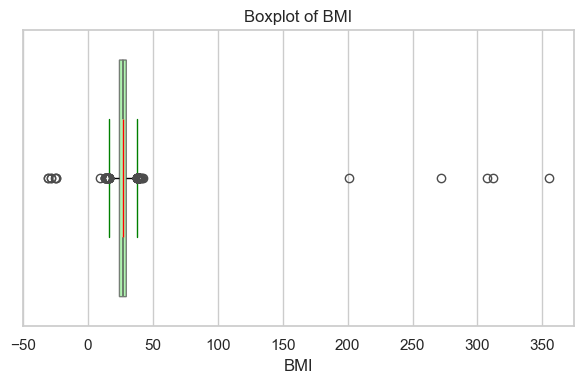

In [31]:
# Create a boxplot of BMI data for IQR rule. Show the median, quartiles in different colors
plt.figure(figsize=(6, 4))
sns.boxplot(x="BMI", data=df, whis=1.5, showfliers=True, notch=True, medianprops=dict(color="red"), boxprops=dict(facecolor="lightgreen", alpha=0.7), whiskerprops=dict(color="black"), capprops=dict(color="green"))
plt.title("Boxplot of BMI")
plt.xlabel("BMI")
plt.tight_layout(); plt.show()

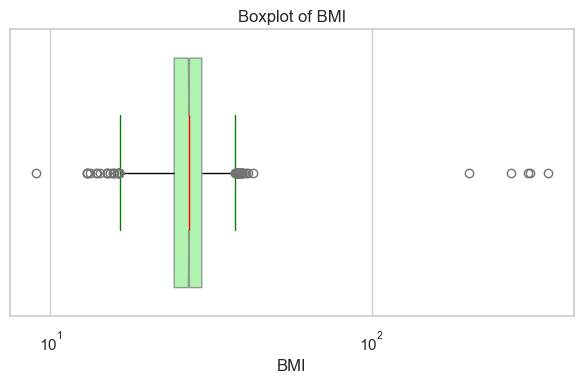

In [32]:
# show the boxplot against a log-scaled x-axis
plt.figure(figsize=(6, 4))
sns.boxplot(x="BMI", data=df, whis=1.5, showfliers=True, notch=True, color='lightgreen', medianprops=dict(color="red"), boxprops=dict(facecolor="lightgreen", alpha=0.7), whiskerprops=dict(color="black"), capprops=dict(color="green"))
plt.title("Boxplot of BMI")
plt.xlabel("BMI")
plt.xscale("log")
plt.tight_layout(); plt.show()

Now let's calculate how many BMI outliers we have. Complete the code below to calculate and print the number of outliers according to the IQR rule.

In [33]:
from scipy import stats
## IQR method
q1, q3 = df["BMI"].quantile([0.25, 0.75])
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

print(f"IQR fences: {lower:.1f} – {upper:.1f}")

# complete the code to calculate and print the number of outliers according to the IQR rule
iqr_outliers = df[(df["BMI"] < lower) | (df["BMI"] > upper)]

print(f"IQR method: {len(iqr_outliers)} outliers (outside {lower:.1f}–{upper:.1f})")

IQR fences: 16.4 – 37.6
IQR method: 64 outliers (outside 16.4–37.6)





#### 🔢 The Z-score rule

The **Z-score** tells us *how many standard deviations a value is away from the mean.*

$
z = \frac{x - \text{mean}}{\text{standard deviation}}
$

If |z| > 3 (more than 3 SD away), it’s likely an outlier — less than 0.3% of normally distributed data fall that far from the mean.

✅ Good for: **normally distributed** variables (like BMI, height, blood pressure).
⚠️ Not ideal for **skewed** variables (like LEDD, which can grow exponentially).


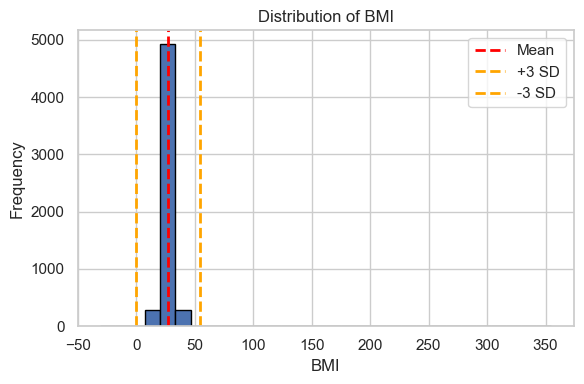

In [34]:
# Visualise the Z-score rule using histogram with standard deviation lines
plt.figure(figsize=(6, 4))
plt.hist(df["BMI"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
mean_bmi = df["BMI"].mean()
std_bmi = df["BMI"].std()
plt.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_bmi + 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='+3 SD')
plt.axvline(mean_bmi - 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='-3 SD')
plt.legend()
plt.tight_layout(); 
plt.show()

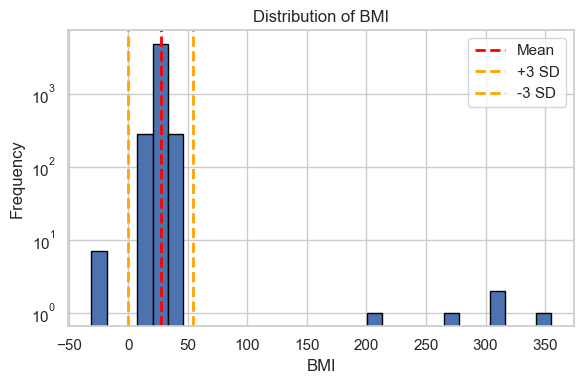

In [35]:
# Visualise the Z-score rule using histogram with standard deviation lines on log-scaled y-axis
plt.figure(figsize=(6, 4))
plt.hist(df["BMI"].dropna(), bins=30, edgecolor="black")
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
mean_bmi = df["BMI"].mean()
std_bmi = df["BMI"].std()
plt.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_bmi + 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='+3 SD')
plt.axvline(mean_bmi - 3*std_bmi, color='orange', linestyle='dashed', linewidth=2, label='-3 SD')
plt.legend()
plt.yscale("log")
plt.tight_layout(); plt.show()

Now let's calculate how many outliers we have according to the Z-score rule. Complete the code below to calculate and print the number of outliers.

In [36]:
# Z-score method
z_scores = stats.zscore(df["BMI"].dropna())

z_outliers = df.loc[df["BMI"].dropna().index[np.abs(z_scores) > 3]]
print(f"Z-score method: {len(z_outliers)} outliers (|z| > 3)")


Z-score method: 12 outliers (|z| > 3)


### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>
1. Look at the distributions below, can you spot variables with potential outliers in the datasets? 
2. When you do, try to:
* Visualise the variable distributions with a histogram and a boxplot.
* Calculate how many outliers exist using both the IQR and Z-score methods.






In [37]:
# Write your code here


## ⚕️ Handling Outliers in LEDD (exponential distribution)

Unlike BMI, **LEDD** values are **highly skewed** — most patients have modest doses, but a few take extremely large ones.
This happens naturally in Parkinson’s disease as treatment escalates over time.

**Challenge:** Traditional outlier rules (IQR or Z-score) treat the right-hand tail as “bad,” but here the tail is *expected*.

Instead of “removing outliers,” we can:

1. **Transform** the data (log-scale) so the tail compresses.
2. **Winsorise** (cap extremes) if we only want to summarise robustly.
3. **Use quantile-based trimming** (keep, say, 1st–99th percentile).

> Let's visualise LEDD once again and see the heavy right tail

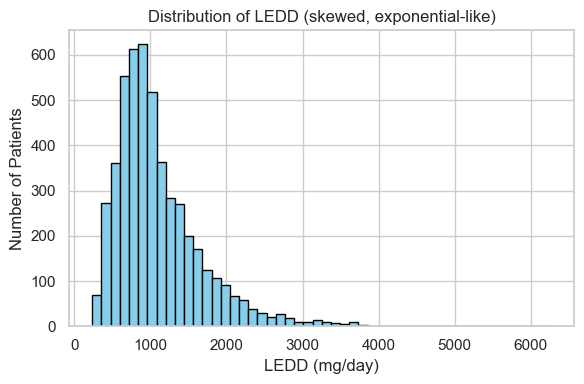

In [68]:
plt.figure(figsize=(6,4))
plt.hist(df["LEDD"].dropna(), bins=50, edgecolor="black", color="skyblue")
plt.title("Distribution of LEDD (skewed, exponential-like)")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

> Now, let's apply a log transformation for inspection! But now it's your turn to complete the code!

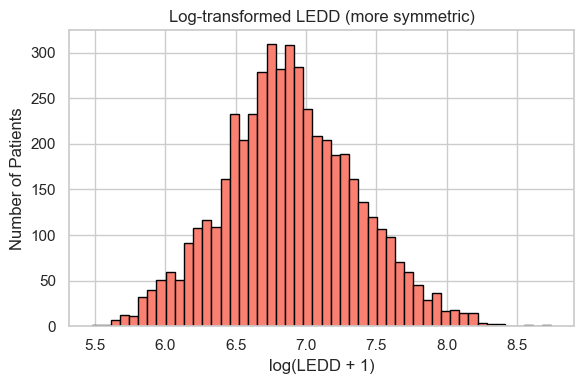

In [69]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(df["LEDD"].dropna()), bins=50, edgecolor="black", color="salmon")
plt.title("Log-transformed LEDD (more symmetric)")
plt.xlabel("log(LEDD + 1)")
plt.ylabel("Number of Patients")
plt.tight_layout() 
plt.show()

#### Detecting LEDD outliers using **percentile trimming**
When data are naturally skewed, it’s safer to flag only the *most extreme* few percent rather than using z-scores.

In [40]:
low, high = df["LEDD"].quantile([0.01, 0.99])
mask_trim = (df["LEDD"] < low) | (df["LEDD"] > high)

print(f"1st–99th percentile range: {low:.1f} – {high:.1f}")
print("Extreme LEDD values flagged:", int(mask_trim.sum()))

1st–99th percentile range: 345.7 – 3181.7
Extreme LEDD values flagged: 100



## 🧮 Winsorise LEDD for robust plots

#### 📚 What is *Winsorisation*?

**Winsorisation** (pronounced *win-sor-ization*) is a method used to **limit the influence of extreme values (outliers)** *without removing any data points*.

Instead of deleting the most extreme observations, we **replace** them with values at a chosen percentile threshold.

#### 💡 Intuitive Example

Imagine you have a dataset of daily medication doses for 1000 patients.
Most values are between **200 and 1500 mg**, but one data entry error says **15,000 mg**.
That one error will:

* stretch your histogram,
* distort your mean and standard deviation, and
* make your plots harder to interpret.

With **Winsorisation**, you *keep that data point*,
but you **cap** it at a reasonable upper limit — say the **99th percentile (≈ 1500 mg)**.

So instead of deleting the record, you replace:

> `15,000 → 1500`

You do the same for the lowest tail if needed.

#### ⚖️ Formal definition

If we Winsorise at the **1% and 99% levels**, we:

* Replace all values **below** the 1st percentile with the value at the 1st percentile.
* Replace all values **above** the 99th percentile with the value at the 99th percentile.

Mathematically:

$$
x_i' =
\begin{cases}
x_{p01}, & \text{if }~x_i < x_{p01}, \\
x_i, & \text{if }~x_{p01} \le x_i \le x_{p99}, \\
x_{p99}, & \text{if }~x_i > x_{p99}.
\end{cases}
$$

Where $x_{p01}$ and $x_{p99}$ are the 1st and 99th percentile values.



---

#### 🧠 Why use it?

* **Keeps all data points** (no deletion)
* **Reduces distortion** from rare errors or extreme but unimportant values
* **Improves robustness** of means and regressions
* **Makes histograms clearer** by “squashing” tails

⚠️ **However**:

* Winsorisation changes the actual data values, so it should only be used for **descriptive analysis or visualisation**, *not for inferential modelling* where true values matter.






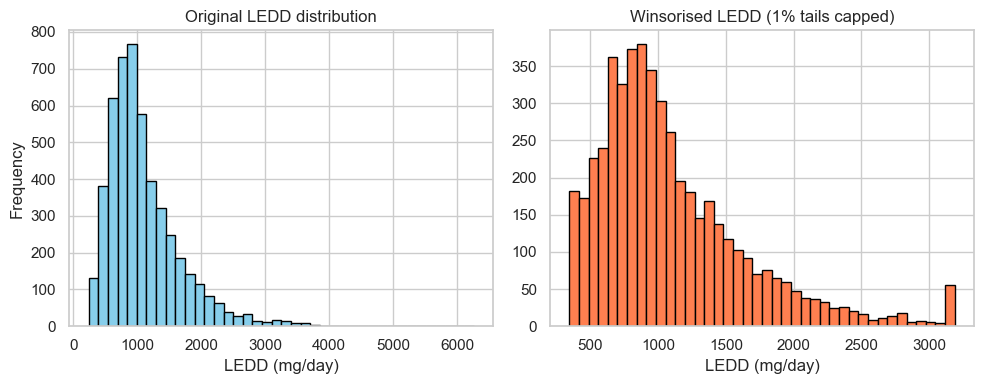

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Example: skewed LEDD values (as in your dataset)
x = df["LEDD"].dropna()

# Winsorise at 1% and 99%
x_winsor = winsorize(x, limits=[0.01, 0.01])

# Visualise the difference
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(x, bins=40, edgecolor="black", color="skyblue")
plt.title("Original LEDD distribution")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(x_winsor, bins=40, edgecolor="black", color="coral")
plt.title("Winsorised LEDD (1% tails capped)")
plt.xlabel("LEDD (mg/day)")
plt.tight_layout(); plt.show()

### 🍎 <span style="color:red; font-weight:bold">Student challenge 

<span style="color:red; font-weight:bold">Now your turn!</span>

UPDRS III is a clinical rating scale for Parkinson's disease motor symptoms. It typically ranges from 0 to 132, with higher scores indicating more severe symptoms. However, in real-world datasets, you might encounter outliers due to data entry errors. Firstly, try to see how many datapoints lie outside of the 0 to 132 range

In [42]:
# See how many UPDRS III values lie outside of the 0 to 132 range


### To clean this, we can either use capping or winsorisation.

Capping would involve converting any extreme values to the value of the closest boundary - setting any values below 0 to 0, and any values above 132 to 132.

Try to implement capping below. 

P.S. use your pandas cheatsheet to find a one-liner method to cap values within a range:
[Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

In [43]:
# Implement your capping method here (turn values outside 0-132 to nearest boundary)




Winsorising, on the other hand is done on percentiles (e.g., 1% and 99%, or 0.5% and 99.5%). Experiment with different percentile levels to see how they affect the distribution to try to find the one that aligns best with clinical expectations.

In [44]:
# Experiment with different percentiles for winsorisation and see how it affects the distribution




# visualise the distributions before and after winsorisation for different percentiles

### Now let's compare the effect of capping vs winsorisation on the UPDRS III distribution. 

Visualise your best winsorised percentile alongside the capped and original distributions below


In [45]:
# Write your code here 

#### <span style="color:red">Please answer below: which method (capping or winsorisation) do you think is better for cleaning UPDRS III, and why?



### ✅ Summary

| Aspect         | Winsorisation                                                        |
| -------------- | -------------------------------------------------------------------- |
| **Goal**       | Reduce the impact of extreme outliers without deleting data          |
| **How**        | Replace extreme values with percentile thresholds (e.g., 1st & 99th) |
| **Use when**   | You want robust summaries or clean visualisations                    |
| **Avoid when** | You need to preserve every raw data value for inference or auditing  |




---

### ✅ Key Points for Handling Outliers

* **Always inspect** data distributions visually first.
* Use **IQR or Z-score** rules to flag unusual values.
* Apply **domain logic** — e.g., BMI < 10 or > 60 → impossible, set to `NaN`.
* For analysis where you can’t remove extremes, use **Winsorisation**.
* Only after cleaning, proceed to **imputation**.


---

### 📚 References

* SciPy `stats.zscore`: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)
* SciPy `mstats.winsorize`: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html)
* Vetter, T. R. & Mascha, E. J. (2017). *Outliers and their impact on statistical analysis in medical research.* *Anesthesia & Analgesia*, 125(2), 755–760.


### 🧹 Removing duplicates (without losing real repeated measures)

In real datasets, “duplicates” can mean different things:

1. **Exact row duplicates**

   * Every column matches another row 1:1 (true copy-paste/merge artifact).
   * ✅ Safe to drop.

2. **Key duplicates** (same *entity + time/visit* appears more than once)

   * E.g., the same `patient_id` at the same `years_since_dx`.
   * Might be **legit** (two forms for the same visit) or **accidental** (double entry).
   * 🔎 Inspect first; if you must collapse, prefer a **deterministic rule** (e.g., keep the first, or aggregate with mean/median).

3. **Legit repeats** (longitudinal)

   * Same `patient_id` across *different* `years_since_dx`.
   * ✅ Keep—these are your repeated measures.

Below, we (a) remove exact duplicates, (b) *flag* suspected key duplicates for review, and (c) (optionally) resolve them with a transparent rule.

In [46]:
# --- 1) Remove exact row duplicates (safe) ---
n_before = len(df)
df_no_exact_dups = df.drop_duplicates(keep="first").copy()
n_removed_exact = n_before - len(df_no_exact_dups)
print(f"Removed {n_removed_exact} exact duplicate rows.")

Removed 40 exact duplicate rows.


In [47]:

# --- 2) Flag potential "key duplicates" (same patient & same visit/time) ---
# Define a visit-level key. Here: patient + years_since_dx (adjust if your real data uses visit_date, visit_id, etc.)
visit_key = ["patient_id", "years_since_dx"]

dup_mask = df_no_exact_dups.duplicated(subset=visit_key, keep=False)
suspected_key_dups = df_no_exact_dups.loc[dup_mask].sort_values(visit_key)

print(f"Potential key duplicates (same {visit_key}) found: {suspected_key_dups.shape[0]} rows"
      f" across {suspected_key_dups.groupby(visit_key).ngroups} visit keys.")

Potential key duplicates (same ['patient_id', 'years_since_dx']) found: 320 rows across 160 visit keys.


In [48]:
# Peek at a few problematic keys
display(
    suspected_key_dups
      .groupby(visit_key, as_index=False)
      .size()
      .sort_values("size", ascending=False)
      .head(10)
)

,patient_id,years_since_dx,size
0,P0015,1.87,2
1,P0032,2.50,2
102,P3362,5.67,2
103,P3373,8.00,2
104,P3419,8.94,2
105,P3434,11.22,2
106,P3482,7.84,2
107,P3484,10.71,2
108,P3528,3.73,2
109,P3532,1.23,2


In [49]:
# Optional: inspect the first few full records for a specific key (uncomment & set a key you saw above)
suspected_key_dups.query("patient_id == 'P4071' and years_since_dx == 2.16").head()

,patient_id,sex,years_since_dx,age,ethnicity,BMI,LEDD,updrs_iii,log_LEDD,years_band,age_group
4071,P4071,Male,2.16,43.9,Black,28.6,1346.24809,NaN,7.205819,2–5,<=55
5171,P4071,Male,2.16,43.9,Black,28.2,1351.40000,NaN,7.209636,2–5,<=55


In [50]:
# --- 3) (Optional) Resolve key duplicates with a clear rule ---
# If you decide that duplicates within a visit_key are accidental, choose ONE policy and document it.
# Here are two common approaches. Pick ONE and keep it consistent.

# A) Keep the first occurrence (deterministic, preserves original values)
df_keep_first = (
    df_no_exact_dups
      .sort_values(visit_key)        # ensure deterministic order
      .drop_duplicates(subset=visit_key, keep="first")
      .copy()
)

In [51]:
# B) Aggregate numeric columns within the same key (robust when multiple entries disagree)
numeric_cols = df_no_exact_dups.select_dtypes("number").columns.tolist()
non_numeric = [c for c in df_no_exact_dups.columns if c not in numeric_cols]

df_agg = (
    df_no_exact_dups
      .groupby(visit_key, as_index=False)
      .agg({**{c: "first" for c in non_numeric if c not in visit_key},  # keep first label/categorical
            **{c: "median" for c in numeric_cols}})                      # median is robust to outliers
)



In [52]:
# --- 4) Pick the final cleaned version you want to use downstream ---
# If you opted to just remove exact duplicates: use df_no_exact_dups
# If you resolved key duplicates by policy A: use df_keep_first
# If you resolved key duplicates by policy B: use df_agg

df_clean = df_keep_first  # <- choose one: df_no_exact_dups / df_keep_first / df_agg
print(f"Final rows after chosen policy: {len(df_clean)}")


Final rows after chosen policy: 5300


In [53]:

# --- 5) Sanity checks ---
# a) No exact duplicates remain:
assert not df_clean.duplicated().any(), "Exact duplicates still present."
# b) If you intended to be unique by visit_key:
assert not df_clean.duplicated(subset=visit_key).any(), "Key duplicates remain under chosen policy."

# Optional: quick summary of repeat structure (legit longitudinal pattern)
repeat_counts = df_clean.groupby("patient_id").size().describe()
print("\nVisits per patient (after cleaning):")
print(repeat_counts)


Visits per patient (after cleaning):
count    5000.000000
mean        1.060000
std         0.237511
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64


Count here describes the number of unique patients, whereas the mean shows the average number of visits per patient.

In [54]:
# Let's show the patients with more than 1 visit on different dates (should be legit longitudinal repeats)
multi_visit = df_clean.groupby("patient_id").filter(lambda x: len(x) > 1)
print(f"\nPatients with multiple visits: {multi_visit['patient_id'].nunique()} patients, {len(multi_visit)} total visits")


Patients with multiple visits: 300 patients, 600 total visits






**Notes & tips**

* If your real data has a true `visit_id` or a `visit_date`, prefer that (or `patient_id + visit_date`) as the key.
* Always **log your choice** (e.g., “key duplicates collapsed by median per visit key”) so results are reproducible.
* If two entries within the same key strongly disagree (e.g., `age` or `sex` differ), **don’t auto-aggregate**—flag for manual review.
* <span style="color: orange;"> **EXACT DUPLICATES CAN STILL BE MEANINGFUL** - e.g., in medication logs the same drug with the same dose/quantity/duration could be prescribed on the same day, indicating *bulk prescriptions*. **You should always interpret duplicates in the context of the data source and domain knowledge** </span>




## 🧩 Missingness & Imputation 

Real-world **medical and EHR data** are almost never complete — sensors fail, tests aren’t ordered, or data entry is inconsistent.
Before analysis, we must understand **what’s missing** and **how to handle it**.

---

### 🧠 Types of Missingness

| Type                                    | Meaning                                                        | Example                                                               |
| --------------------------------------- | -------------------------------------------------------------- | --------------------------------------------------------------------- |
| **MCAR** — Missing Completely At Random | The missingness has nothing to do with the data (pure chance). | A lab result is lost due to a computer crash.                         |
| **MAR** — Missing At Random             | Missingness relates to other *observed* data.                  | Older patients have more missing UPDRS scores.                        |
| **MNAR** — Missing Not At Random        | Missingness depends on the *unobserved* value itself.          | Patients with very severe UPDRS are less likely to attend the clinic. |

In real data, MCAR is rare — most missingness is *MAR-like*, which means we can sometimes predict it from other variables.



#### 1️⃣ Check How Much Data Is Missing

Let’s start by seeing **where and how much** is missing.


In [55]:
# Check total missing values per column
df.isna().sum()

patient_id          0
sex                51
years_since_dx      0
age               109
ethnicity         277
BMI                 0
LEDD              550
updrs_iii         519
log_LEDD          550
years_band          0
age_group         119
dtype: int64

You can also see this as **percentages**:

In [56]:

(df.isna().mean() * 100).round(1)

patient_id         0.0
sex                0.9
years_since_dx     0.0
age                2.0
ethnicity          5.0
BMI                0.0
LEDD              10.0
updrs_iii          9.4
log_LEDD          10.0
years_band         0.0
age_group          2.2
dtype: float64

#### 🔍 Visualize Missingness

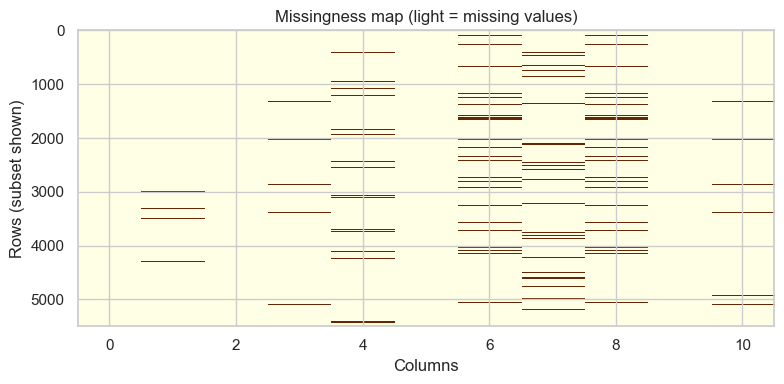

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(df.isna(), aspect="auto", interpolation="none", cmap="YlOrBr")
plt.title("Missingness map (light = missing values)")
plt.xlabel("Columns")
plt.ylabel("Rows (subset shown)")
plt.tight_layout()
plt.show()

This quick “heatmap” shows missing cells as lighter areas — typical in longitudinal EHRs where not every test is recorded at each visit.

## 2️⃣ Simple Ways to Handle Missing Data

The two simplest approaches are:

### (a) Drop missing rows or columns

Good when **few values are missing** and losing those rows won’t hurt your analysis.

In [58]:
# Drop any rows that contain missing values
df_drop = df.dropna()
print("Before:", df.shape, "| After drop:", df_drop.shape)

Before: (5500, 11) | After drop: (4104, 11)


### (b) Fill missing values (imputation)

When you can’t afford to drop rows, you can **fill in** missing numbers with a reasonable estimate.

#### Option 1 — Fill numeric columns with their mean or median

In [59]:
from sklearn.impute import SimpleImputer

# choose numeric columns
num_cols = ["LEDD", "updrs_iii", "age", "years_since_dx"]

df_simp_impute = df.copy()
# Impute using median strategy
imputer = SimpleImputer(strategy="median")  # or "mean"
df_simp_impute[num_cols] = imputer.fit_transform(df[num_cols])

#### Option 2 — Fill categories with a constant (e.g., “Unknown”)

In [60]:
cat_cols = ["sex", "ethnicity"]
    
df_simp_impute[cat_cols] = df_simp_impute[cat_cols].fillna("Unknown")



#### 🧮 Check that it worked

In [61]:
df_simp_impute.isna().sum()

patient_id          0
sex                 0
years_since_dx      0
age                 0
ethnicity           0
BMI                 0
LEDD                0
updrs_iii           0
log_LEDD          550
years_band          0
age_group         119
dtype: int64

#### 3️⃣ Quick Visual Check Before and After Imputation

We can look at how imputation changes a variable’s distribution — here for LEDD.

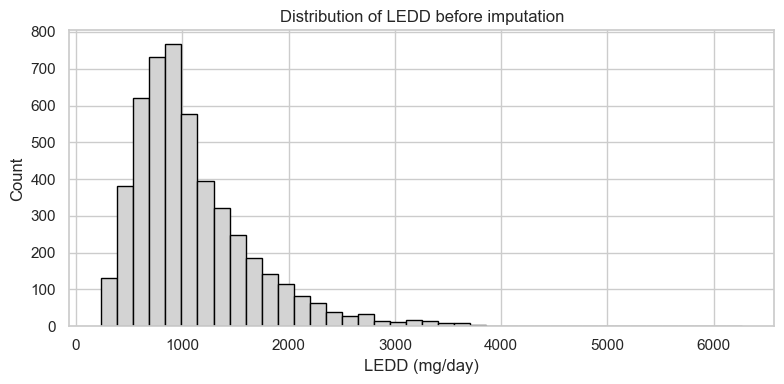

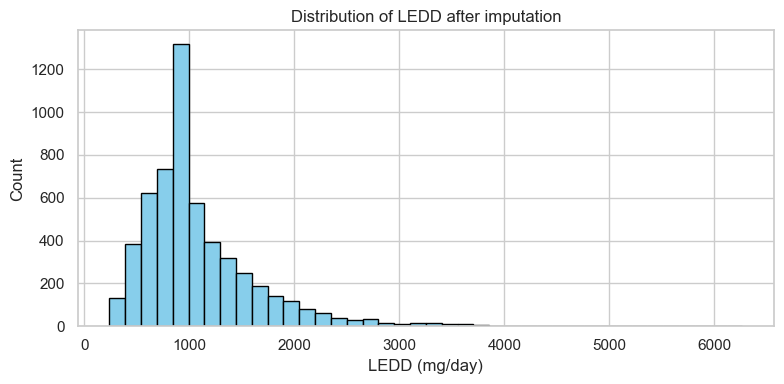

In [62]:
plt.figure(figsize=(8, 4))
plt.hist(df["LEDD"].dropna(), bins=40, edgecolor="black", color="lightgrey")
plt.title("Distribution of LEDD before imputation")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(df_simp_impute["LEDD"], bins=40, edgecolor="black", color="skyblue")
plt.title("Distribution of LEDD after imputation")
plt.xlabel("LEDD (mg/day)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



> 💡 **Note:** Mean or median imputation doesn’t “invent” information — it just makes the dataset usable for analysis.
> For serious clinical modeling, you’d later learn more advanced approaches (like *multiple imputation* or *model-based* filling).


#### 4️⃣ Summary — What to Remember

* **Always check** how much and where data are missing before analysis.
* **Dropping** rows is fine for small gaps; **imputation** helps when missingness is common.
* **Numeric variables** → fill with *mean* or *median*.
* **Categorical variables** → fill with *“Unknown”* or *most frequent value*.
* Keep a **copy of the original data** so you can compare before/after imputation.




### 🚀 Advanced Imputation — Linear Models & MICE

So far, we’ve used **simple univariate imputation** (mean/median).
This works when missingness is *small* and *random*, but it can distort relationships between variables.
To better preserve *correlations and variance*, we can use **model-based imputation**.

---

#### 🧠 Why go beyond simple imputation?

| Method                             | When to use                                                       | How it works                                  | Pros                                             | Cons                           |
| ---------------------------------- | ----------------------------------------------------------------- | --------------------------------------------- | ------------------------------------------------ | ------------------------------ |
| **Mean / median**                  | Few missing values; MCAR                                          | Replace missing with a constant               | Simple, fast                                     | Reduces variance; weak for MAR |
| **Linear (regression) imputation** | Missing values depend on other *continuous predictors*            | Fit a linear model to predict missing values  | Keeps relationships between variables            | Can overfit if predictors weak |
| **MICE (Chained Equations)**       | Several variables have missingness, possibly interdependent (MAR) | Iteratively models each variable using others | Preserves multivariate structure; more realistic | Slower; assumes MAR            |






## 1️⃣ Linear (Regression-Based) Imputation

Suppose some `LEDD` values are missing, but we have related variables like `years_since_dx` and `updrs_iii`.

We can predict the missing LEDD values using a **linear regression model** fitted on the complete cases.

In [63]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make a copy to work with
df_linimp = df.copy()

# Define features and target
features = ["years_since_dx", "updrs_iii", "age"]
target = "LEDD"

# 1) Separate rows with and without missing LEDD
mask_missing = df_linimp[target].isna()
train_df = df_linimp.loc[~mask_missing, features + [target]].dropna()
predict_df = df_linimp.loc[mask_missing, features].dropna()

# 2) Fit linear model on complete cases
lin_model = LinearRegression()
lin_model.fit(train_df[features], train_df[target])

# 3) Predict missing LEDD
predicted = lin_model.predict(predict_df[features])
df_linimp.loc[predict_df.index, target] = predicted

print(f"Imputed {len(predicted)} missing LEDD values using linear regression.")

Imputed 508 missing LEDD values using linear regression.



**When to use:**

* When missingness is likely **MAR** (depends on other observed variables).
* When predictors (like disease duration or motor severity) are good correlates of the target.

**Advantages:**

* Preserves relationships between variables.
* Doesn’t collapse variability as mean imputation does.

**Limitations:**

* Assumes linearity.
* Only imputes one variable at a time (univariate target).


#### 2️⃣ MICE — Multivariate Imputation by Chained Equations

**Motivation:**
When several variables (e.g., `LEDD`, `UPDRS_III`, `age`) are missing at once, imputing one variable at a time using the others iteratively better reflects their mutual relationships.

This is often appropriate for **MAR** data in longitudinal or clinical studies.


In [64]:
# enable experimental API
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# select relevant numeric variables
mice_cols = ["LEDD", "updrs_iii", "age", "years_since_dx"]
df_mice = df[mice_cols].copy()

# create and run imputer
mice = IterativeImputer(random_state=0, max_iter=10)
df_mice_imputed = pd.DataFrame(mice.fit_transform(df_mice),
                               columns=mice_cols,
                               index=df.index)

# replace imputed values back into the dataset
df_mice[mice_cols] = df_mice_imputed[mice_cols]
df_mice.head()

,LEDD,updrs_iii,age,years_since_dx
0,818.300000,44.900000,66.6,10.62
1,911.936129,31.957703,52.5,8.29
2,1242.933872,27.852806,63.4,5.78
3,1683.987581,34.412344,70.2,8.15
4,788.200000,35.400000,53.4,10.03




**What it does (in simple terms):**

1. Start by filling missing values with simple guesses (e.g., means).
2. Pick one variable with missing values (e.g., `LEDD`).
3. Predict its missing values using all other variables in the dataset.
4. Repeat this for each variable with missing data, cycling through several times.

After several iterations, the imputations stabilize.

### 🔍 Compare LEDD Distributions (before vs after imputation)

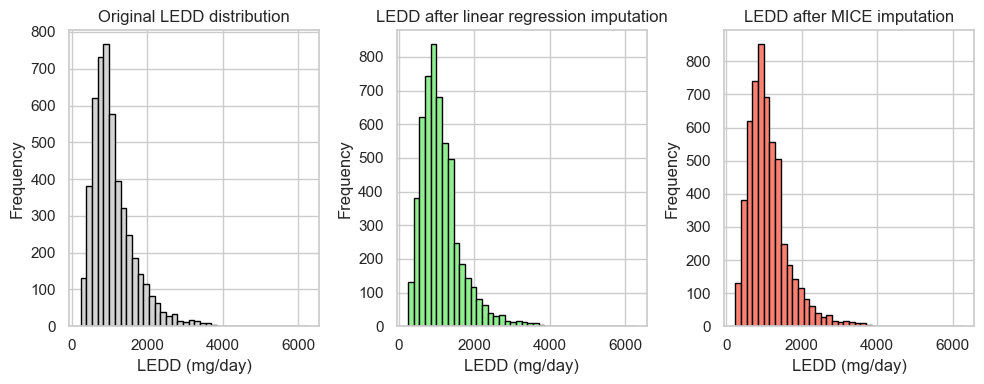

In [65]:
import matplotlib.pyplot as plt 

# Compare LEDD distributions before and after imputation on different subplots

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.hist(df["LEDD"].dropna(), bins=40, edgecolor="black", color="lightgrey")
plt.title("Original LEDD distribution")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")            
plt.subplot(1,3,2)
plt.hist(df_linimp["LEDD"], bins=40, edgecolor="black", color="lightgreen")
plt.title("LEDD after linear regression imputation")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")
plt.subplot(1,3,3)
plt.hist(df_mice["LEDD"].dropna(), bins=40, edgecolor="black", color="salmon")
plt.title("LEDD after MICE imputation")
plt.xlabel("LEDD (mg/day)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()
# Visualise the pairwise relationships between numeric variables    


**Interpretation:**

* Linear imputation and MICE maintain more realistic LEDD variability.
* Compare with simple mean/median imputation — those would produce artificial spikes.
* Always inspect histograms to check plausibility of imputed values.


### ⚕️ When to Use These in Biomedical Analysis

| Scenario                                                    | Recommended Method                           |
| ----------------------------------------------------------- | -------------------------------------------- |
| Small, random gaps                                          | Mean or median imputation                    |
| LEDD missing but other clinical predictors complete         | Linear (regression) imputation               |
| Several clinical variables missing (e.g., LEDD, UPDRS, Age) | MICE / Iterative imputation                  |
| Highly nonlinear data                                       | Model-based imputation (e.g., random forest) |









### 📚 References and Further Reading

**Practical documentation**

* scikit-learn `SimpleImputer`:
  [https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
* scikit-learn `IterativeImputer` (MICE implementation):
  [https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)

**Key academic references**

* Little, R.J.A. & Rubin, D.B. (2019). *Statistical Analysis with Missing Data* (3rd ed.). Wiley.
* Sterne, J.A.C. et al. (2009). *Multiple imputation for missing data in epidemiological and clinical research.* *BMJ*, 338:b2393.
* Van Buuren, S. (2018). *Flexible Imputation of Missing Data* (2nd ed.). Chapman & Hall/CRC.

